In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is available.")

cuda is available.


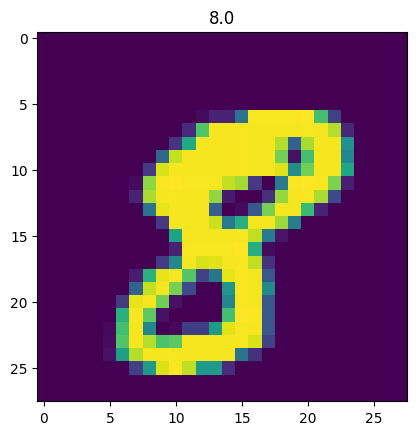

In [4]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv', dtype = np.float32)

# pd轉為numpy
features_numpy = train.loc[:, train.columns != 'label'].to_numpy()/255 #正規化輸入feature
targets_numpy = train['label'].to_numpy()
#分割驗證集
features_train, features_val, targets_train, targets_val = train_test_split(features_numpy, targets_numpy, test_size=0.2, random_state=0)
#numpy轉為tensor
featurestrain = torch.from_numpy(features_train)
targetstrain = torch.from_numpy(targets_train).type(torch.LongTensor)
featuresval = torch.from_numpy(features_val)
targetsval = torch.from_numpy(targets_val).type(torch.LongTensor)

batch_size = 100
epochs = 30
# DataLoader 前需透過TensorDataSet將X, y一個一個綁在一起
train = TensorDataset(featurestrain, targetstrain)
val = TensorDataset(featuresval, targetsval)
# DataLoader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

plt.imshow(features_numpy[10].reshape(28, 28))
plt.title(str(targets_numpy[10]))
plt.show()

In [5]:
class CNNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.cf1 = nn.Linear(32*4*4, 10)

    def forward(self, X):
        a = self.cnn1(X)
        a = F.relu(a)
        a = F.max_pool2d(a, kernel_size=2)

        a = self.cnn2(a)
        a = F.relu(a)
        a = F.max_pool2d(a, 2)

        a = torch.flatten(a, start_dim=1) # 保留batch那個維度 從1維度開始攤平

        out = self.cf1(a)
        return out

model = CNNmodel().to(device)
learning_rate = 0.1

error = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
count = 0
train_loss_list = []
train_acc_list = []
val_loss_list =[]
val_acc_list = []
for epoch in range(epochs):
    total = 0
    correct = 0
    for images, labels in train_loader:
        X = Variable(images.reshape(-1, 1, 28, 28)).to(device) # CNN要確保輸入的batch, channel, width, height
        y = Variable(labels).to(device)

        optimizer.zero_grad()

        outputs = model(X)

        loss = error(outputs, y)

        loss.backward()

        optimizer.step()

        count += 1

        if count % 100 == 0:
            total += len(y)
            _, predicted = torch.max(outputs.data, axis=1)
            correct += (predicted == y).sum()
            acc = (100* (correct/total)).item()
            print(f"iteration:{count}, loss:{loss.item()}, acc:{acc}%")
        if count % 336 == 0:
            train_loss_list.append(loss.item())
            train_acc_list.append(acc)

    val_loss = 0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            val_total += len(labels)
            outputs = model(images.reshape(-1, 1, 28, 28)) # CNN要確保輸入的batch, channel, width, height
            val_loss += error(outputs, labels).item()
            _, predicted = torch.max(outputs.data, axis=1)
            val_correct += (predicted == labels).sum()
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = (100 * (val_correct / val_total)).item() # 因為有丟入device所以需要注意 GPU Tensor取值
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    print(f"epoch{epoch + 1}, val_loss:{avg_val_loss}, val_acc:{avg_val_acc}%")

iteration:100, loss:0.3523126244544983, acc:84.0%
iteration:200, loss:0.17253424227237701, acc:89.5%
iteration:300, loss:0.0944274365901947, acc:92.33333587646484%
epoch1, val_loss:0.1284391519480518, val_acc:96.25%
iteration:400, loss:0.12085872888565063, acc:96.0%
iteration:500, loss:0.02799042873084545, acc:97.99999237060547%
iteration:600, loss:0.07074142247438431, acc:97.66667175292969%
epoch2, val_loss:0.09056743398486149, val_acc:97.29762268066406%
iteration:700, loss:0.10902741551399231, acc:97.0%
iteration:800, loss:0.04002562537789345, acc:97.99999237060547%
iteration:900, loss:0.036784227937459946, acc:98.33333587646484%
iteration:1000, loss:0.051364459097385406, acc:98.24999237060547%
epoch3, val_loss:0.07639339723668638, val_acc:97.6547622680664%
iteration:1100, loss:0.12892913818359375, acc:95.0%
iteration:1200, loss:0.02708030305802822, acc:97.5%
iteration:1300, loss:0.0817115306854248, acc:97.33333587646484%
epoch4, val_loss:0.06720649332384623, val_acc:97.9285736083984

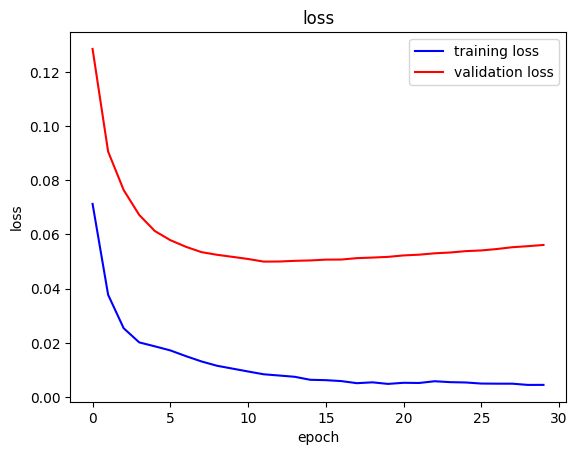

In [7]:
plt.plot(range(epochs), train_loss_list, label='training loss', color='blue')
plt.plot(range(epochs), val_loss_list, label='validation loss', color='red')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss")
plt.show()

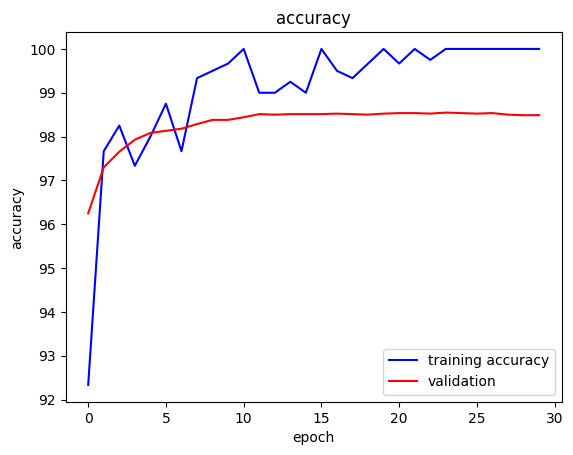

In [8]:
plt.plot(range(epochs), train_acc_list, label="training accuracy", color='blue')
plt.plot(range(epochs), val_acc_list, label="validation", color='red')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.show()

train all training datasets

In [9]:
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv", dtype='float32')

features_np = df.loc[:, df.columns != 'label'].to_numpy()/255
targets_np = df['label'].to_numpy()

X = torch.from_numpy(features_np)
y = torch.from_numpy(targets_np).type(torch.LongTensor)


batch_size = 100
epochs = 30

train = TensorDataset(X, y)

train_loader = DataLoader(train, batch_size=batch_size, shuffle= False)


In [10]:
model = CNNmodel().to(device)
learning_rate = 0.1

error = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
count = 0
train_loss_list = []
train_acc_list = []
for epoch in range(epochs):
    total = 0
    correct = 0
    for images, labels in train_loader:
        X = Variable(images.reshape(-1, 1, 28, 28)).to(device) # CNN要確保輸入的batch, channel, width, height
        y = Variable(labels).to(device)

        optimizer.zero_grad()

        outputs = model(X)

        loss = error(outputs, y)

        loss.backward()

        optimizer.step()

        count += 1

        if count % 100 == 0:
            total += len(y)
            _, predicted = torch.max(outputs.data, axis=1)
            correct += (predicted == y).sum()
            acc = (100* (correct/total)).item()
            print(f"iteration:{count}, loss:{loss.item()}, acc:{acc}%")
    train_loss_list.append(loss.item())
    train_acc_list.append(acc)

iteration:100, loss:0.2806747257709503, acc:91.99999237060547%
iteration:200, loss:0.25802910327911377, acc:90.5%
iteration:300, loss:0.174051895737648, acc:91.33333587646484%
iteration:400, loss:0.09271254390478134, acc:93.0%
iteration:500, loss:0.09635669738054276, acc:97.0%
iteration:600, loss:0.14923065900802612, acc:96.5%
iteration:700, loss:0.12665994465351105, acc:96.0%
iteration:800, loss:0.06857326626777649, acc:96.25%
iteration:900, loss:0.07037315517663956, acc:97.99999237060547%
iteration:1000, loss:0.11410868912935257, acc:97.5%
iteration:1100, loss:0.1371501237154007, acc:97.0%
iteration:1200, loss:0.021683000028133392, acc:97.75%
iteration:1300, loss:0.07037107646465302, acc:97.0%
iteration:1400, loss:0.09352418780326843, acc:96.5%
iteration:1500, loss:0.04177058860659599, acc:97.33333587646484%
iteration:1600, loss:0.010579274035990238, acc:97.99999237060547%
iteration:1700, loss:0.0695965364575386, acc:97.0%
iteration:1800, loss:0.0465281680226326, acc:97.5%
iteration:

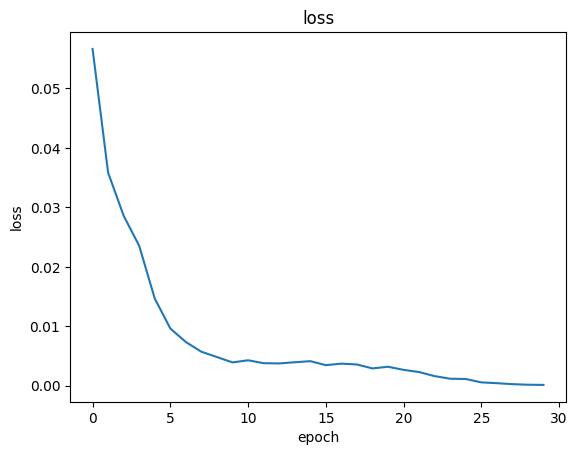

In [12]:
plt.plot(range(epochs), train_loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss")
plt.show()

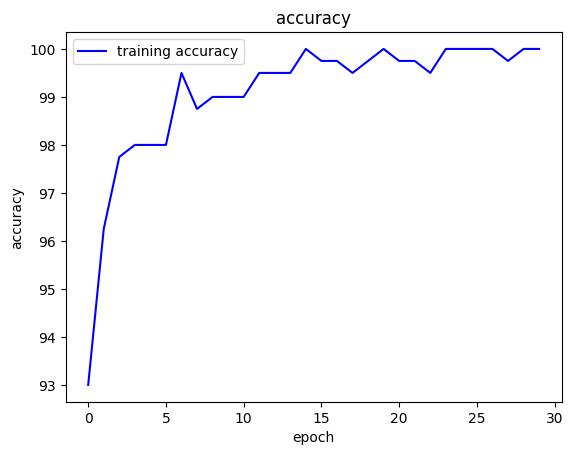

In [13]:
plt.plot(range(epochs), train_acc_list, label="training accuracy", color='blue')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.show()

In [14]:
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv", dtype='float32')

features_np = df_test.to_numpy()/255

test_X = torch.from_numpy(features_np)

test = TensorDataset(test_X)

test_loader = DataLoader(test, batch_size=64)

In [15]:
model.eval()
all_pred = []
with torch.no_grad():
    for (X,) in test_loader:
        X = X.reshape(-1, 1, 28, 28).to(device)
        outputs = model(X)
        _, predict = torch.max(outputs.data, axis=1)
        all_pred.extend(predict.cpu().numpy())

In [16]:
output_df = pd.DataFrame({'ImageID':range(1, len(all_pred)+1), 'Label':all_pred})
output_df = output_df.set_index('ImageID') # 特別注意繳交檔案格式
output_df.to_csv("output_pred.csv")

In [17]:
output_df.head

<bound method NDFrame.head of          Label
ImageID       
1            2
2            0
3            9
4            9
5            3
...        ...
27996        9
27997        7
27998        3
27999        9
28000        2

[28000 rows x 1 columns]>